In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
ticker = "^GSPC"
data = yf.download(ticker, start="1962-01-02", end="2023-01-01")

C:\Users\jdobe\AppData\Local\Temp\ipykernel_22244\2274404261.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="1962-01-02", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


In [3]:
print(data.head())
print(data.shape)

Price           Close       High        Low       Open   Volume
Ticker          ^GSPC      ^GSPC      ^GSPC      ^GSPC    ^GSPC
Date                                                           
1962-01-02  70.959999  71.959999  70.709999  71.550003  3120000
1962-01-03  71.129997  71.480003  70.379997  70.959999  3590000
1962-01-04  70.639999  71.620003  70.449997  71.129997  4450000
1962-01-05  69.660004  70.839996  69.349998  70.639999  4630000
1962-01-08  69.120003  69.839996  68.169998  69.660004  4620000
(15356, 5)


In [4]:
# Create variable Log Returns and further
data["DailyReturn"] = np.log(data["Close"]).diff()
data['Sign_1d'] = (data['DailyReturn'] > 0).astype(int)
data['Volume_change'] = np.log(data['Volume']).diff().shift(1)
data['Trading_range'] = np.log(data['High'] / data['Low']).shift(1)

data = data.iloc[1:]

In [5]:
data["DailyReturn"].describe()

count    15355.000000
mean         0.000260
std          0.010460
min         -0.228997
25%         -0.004327
50%          0.000435
75%          0.005185
max          0.109572
Name: DailyReturn, dtype: float64

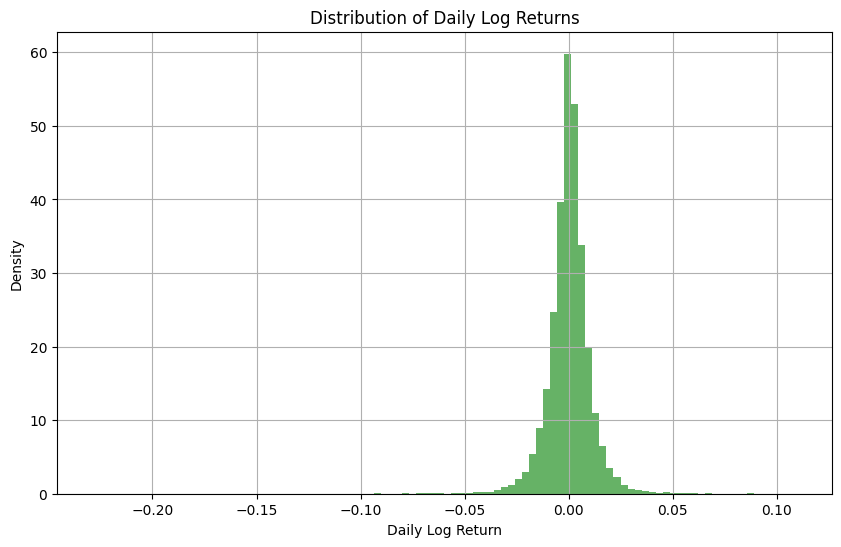

In [6]:
# plot the distribution of daily returns
plt.figure(figsize=(10, 6))
plt.hist(data["DailyReturn"], bins=100, density=True, alpha=0.6, color='g')
plt.title('Distribution of Daily Log Returns')
plt.xlabel('Daily Log Return')
plt.ylabel('Density')
plt.grid()
plt.show()

NOTE: If I use log returns, then there is a zero asset return (mean=0.0002). This would make the use of volatility as predictor for sign return described in Christofferson & Diebold (2006) not applicable to my project.

In [7]:
# Check for normality of returns
jb_stat, jb_p = stats.jarque_bera(data["DailyReturn"].dropna())
print(f"Jarque-Bera test statistic: {jb_stat}, p-value: {jb_p}")

Jarque-Bera test statistic: 404272.34287851123, p-value: 0.0


Hence, the Daily Returns do not follow a normal distribution and sign forecastibility with zero mean asset return but asymmetric distribution from [Christofferson et al.](https://economics.sas.upenn.edu/pier/working-paper/2006/direction-change-forecasts-based-conditional-variance-skewness-and-kurtosis) (2007) could be applied. By the descriptive statistics, it already becomes apparent that there is excess kurtosis, since the minimum return is roughly 22 st.dev. away from the mean. The probability for this to happen is so small, that this return would be even unlikely if we get a return every nanosecond from the start of the universe. Since Pr(Z>22)=2.44x10^-107 for a st.normal distr. Whereas, the universe exists for roughly 4,35x10^26=13,800,000,000x365x24x3600x10^9 nanoseconds.

In [8]:
# get annualized realized volatility
data['Realized_Vol_5d'] = data['DailyReturn'].rolling(window=5).std() * np.sqrt(252)
data['Realized_Vol_20d'] = data['DailyReturn'].rolling(window=20).std() * np.sqrt(252)

# Deep Learning for Sign Classification

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Create loss function that maximizes classification accuracy

In [10]:
class MaximumUtilityLoss(nn.Module):
    """
    Differentiable approximation of the Elliott-Lieli (2013) Maximum Utility estimator.
    Optimizes correct classification rather than probability calibration.
    """
    def __init__(self, c=0.0, sharpness=10.0, w_pos=1.0, w_neg=1.0):
        super().__init__()
        self.c = c
        self.sharpness = sharpness
        self.w_pos = w_pos
        self.w_neg = w_neg

    def forward(self, logits, y):
        y_sign = 2 * y - 1 # -1 or 1
        pred = torch.tanh(self.sharpness * (logits - self.c))  # get a sign approximation
        b = torch.where(y > 0.5, self.w_pos, self.w_neg)
        loss = 1-torch.mean(b * y_sign * pred)
        return loss

In [11]:
NUMBER_OF_LAGS = 5  # number of lagged observations
TRAIN_SIZE = 5000
HIDDEN_DIM = 64
NUM_LAYERS = 4
DROPOUT = 0.0
BATCH_SIZE = 5000
NUMBER_OF_EPOCHS = 50
CLASSIFICATION_THRESHOLD = 0.5
LR = 3e-4

TODO: Add more variables

10 Year US Treasury Bills (Ticker: ^TNX)

In [12]:
ten_y_tbill = yf.download("^TNX", start="1962-01-02", end="2023-01-01")
three_month_tbill = yf.download("^IRX", start="1962-01-02", end="2023-01-01")
oil_price = yf.download("CL=F", start="1962-01-02", end="2023-01-01")
vix_index = yf.download("^VIX", start="1962-01-02", end="2023-01-01")
# merge Open price of interest rates with main data
data = data.merge(ten_y_tbill[["Open"]], left_index=True, right_index=True, how="left", suffixes=('', '_TNX'))
data = data.merge(three_month_tbill[["Open"]], left_index=True, right_index=True, how="left", suffixes=('', '_IRX'))
data = data.merge(oil_price[["Open"]], left_index=True, right_index=True, how="left", suffixes=('', '_CL'))
data = data.merge(vix_index[["Open"]], left_index=True, right_index=True, how="left", suffixes=('', '_VIX'))

# Drop MultiIndex in columns
data.columns = ['_'.join([str(level) for level in col if level]).replace('^', '') for col in data.columns]
data = data.rename(columns={
    ('Open_TNX'): ('ten_y_tnotes'),   
    ('Open_IRX'): ('three_months_tbills'),
    ('Open_CL=F'): ('oil_price'),
    ('Open_VIX'): ('vix_index')
})

C:\Users\jdobe\AppData\Local\Temp\ipykernel_22244\1549595112.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ten_y_tbill = yf.download("^TNX", start="1962-01-02", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\jdobe\AppData\Local\Temp\ipykernel_22244\1549595112.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  three_month_tbill = yf.download("^IRX", start="1962-01-02", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\jdobe\AppData\Local\Temp\ipykernel_22244\1549595112.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  oil_price = yf.download("CL=F", start="1962-01-02", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\jdobe\AppData\Local\Temp\ipykernel_22244\1549595112.py:4: FutureWarning: YF.download() has changed argument auto_adjust def

In [13]:
# print nan values per column
#print(data.isna().sum())

In [14]:
# Add lagged returns as features
data['Return_Lag1'] = data['DailyReturn'].shift(1)
data['oil_price_return'] = np.log(data['oil_price']).diff()
data['vix_return'] = np.log(data['vix_index']).diff()

data.drop(columns=['oil_price', 'oil_price_return', 'vix_index', 'vix_return'], inplace=True)  # dropping oil price due to too many NaNs
data = data.dropna()

# Feature matrix
features = np.column_stack([
    data['Realized_Vol_5d'].values,
    data['Realized_Vol_20d'].values,
    data['Return_Lag1'].values,
    data['Volume_change'].values,
    data['Trading_range'].values,
    data['ten_y_tnotes'].values,
    data['three_months_tbills'].values
    #data['oil_price_return'].values,
    #data['vix_index'].values,
    #data['vix_return'].values
])

input_variables = features.shape[1]

C:\Users\jdobe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
#data.describe()

In [16]:
#features

In [17]:
# Create lagged feature matrix for LSTM
def create_lagged_matrix_multifeature(X, window):
    out = []
    for i in range(window, len(X)):
        out.append(X[i-window:i, :])
    return np.array(out)

X_lagged = create_lagged_matrix_multifeature(features, NUMBER_OF_LAGS)
y_target = data['Sign_1d'].values[NUMBER_OF_LAGS:]

In [18]:
# Split train/test
X_train = X_lagged[:TRAIN_SIZE]
y_train = y_target[:TRAIN_SIZE]
X_test = X_lagged[TRAIN_SIZE:]
y_test = y_target[TRAIN_SIZE:]

# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)

## Define LSTM Model

In [19]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, num_layers=1, dropout=0.0):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.0)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model = SimpleLSTM(input_dim=input_variables, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, dropout=DROPOUT)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()
# pos_weight = (len(y_train_t) / y_train_t.sum())     # ratio of negatives to positives
# neg_weight = (len(y_train_t) / (len(y_train_t) - y_train_t.sum()))
# criterion = MaximumUtilityLoss(w_pos=pos_weight, w_neg=neg_weight, sharpness=6)

## Model Training

X_train_t contains batch size, sequence length (number of lags) and number of variables.
Pytorch automatically calls forward()-method when input is given to the model.

In [20]:
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

model.train()
for epoch in range(NUMBER_OF_EPOCHS+1):     # number of seeing the training data for learning parameters
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.4f}")

Epoch 0: loss = 0.6933
Epoch 10: loss = 0.6928
Epoch 20: loss = 0.6928
Epoch 30: loss = 0.6927
Epoch 40: loss = 0.6926
Epoch 50: loss = 0.6923


### Out of sample Prediction

In [21]:
model.eval()
with torch.no_grad():
    y_pred_test = torch.sigmoid(model(X_test_t)).squeeze().numpy()
    y_pred_sign = (y_pred_test > CLASSIFICATION_THRESHOLD).astype(int)

# --- Results ---
results = pd.DataFrame({
    'Actual_Sign': y_test,
    'Predicted_Sign': y_pred_sign,
    'Pos_probability': y_pred_test
}, index=data.index[NUMBER_OF_LAGS+TRAIN_SIZE:])

In [22]:
# count correct predictions
correct_predictions = (results['Actual_Sign'] == results['Predicted_Sign']).sum()
accuracy = correct_predictions / len(results)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5354


In [23]:
from sklearn.metrics import classification_report, accuracy_score

# Classification report
print("Classification Report:")
print(classification_report(results['Actual_Sign'], results['Predicted_Sign']))
print("Accuracy:", accuracy_score(results['Actual_Sign'], results['Predicted_Sign']))

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.02      0.03      4759
           1       0.54      0.99      0.69      5451

    accuracy                           0.54     10210
   macro avg       0.54      0.50      0.36     10210
weighted avg       0.54      0.54      0.39     10210

Accuracy: 0.5353574926542606


Text(0.5, 1.0, 'Predicted Probability of Positive Return')

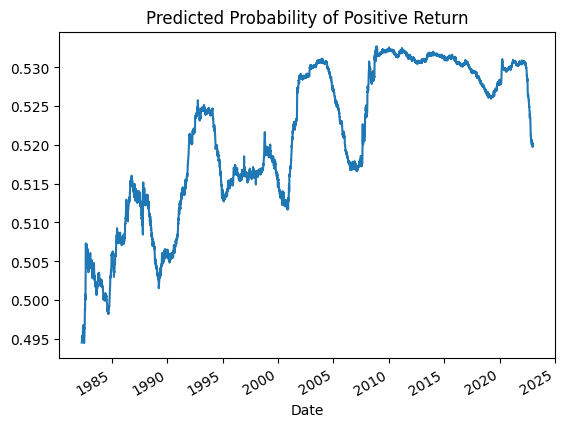

In [24]:
results["Pos_probability"].plot()
plt.title("Predicted Probability of Positive Return")
#plt.ylim(0, 1)

# Forecast Absolute Returns
In the end, just multiply absolute return and sign

# Bringing two forecasts together to predict stock price